In [3]:
import os

In [4]:
os.chdir('/Users/dimitrikestenbaum/Desktop/RecSys')

In [5]:
import pandas as pd 
import numpy as np 
from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic, SVD
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [34]:
user_taggedartists_df = pd.read_table('Data-20220224/Data Group Assignment/user_taggedartists.dat')

In [35]:
user_taggedartists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [1]:
def two_dig(num):
    """
    This function takes a number as input and casts it to a string. 
    If the length of the str is equal to 1 it concatenates a 0 in front of it.
    This can be applyed to day and month columns that are recorded a single digit 
    in order to meet the two-digit format native to most datetime formats. 
    
    Params: num: A 
    """
    if len(str(num)) == 1:
        return((str(0) + str(num)))
    else:
        return(str(num))

In [37]:
user_taggedartists_df['day'] = user_taggedartists_df['day'].map(lambda x: two_dig(x))

In [38]:
user_taggedartists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,01,4,2009
1,2,52,15,01,4,2009
2,2,52,18,01,4,2009
3,2,52,21,01,4,2009
4,2,52,41,01,4,2009


In [39]:
user_taggedartists_df['month'] = user_taggedartists_df['month'].map(lambda x: two_dig(x))

In [40]:
user_taggedartists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,01,04,2009
1,2,52,15,01,04,2009
2,2,52,18,01,04,2009
3,2,52,21,01,04,2009
4,2,52,41,01,04,2009


In [41]:
user_taggedartists_df['release_date'] = pd.to_datetime((user_taggedartists_df['year'].astype('str') + user_taggedartists_df['day'] + user_taggedartists_df['month']),format='%Y%d%m')

In [42]:
user_taggedartists_df.drop(columns=['day','month','year'],axis=1,inplace=True)

In [43]:
user_taggedartists_df.head()

,userID,artistID,tagID,release_date
0,2,52,13,2009-04-01
1,2,52,15,2009-04-01
2,2,52,18,2009-04-01
3,2,52,21,2009-04-01
4,2,52,41,2009-04-01


(array([4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.13500e+03, 1.84339e+05]),
 array([-4962. , -2955.5,  -949. ,  1057.5,  3064. ,  5070.5,  7077. ,
         9083.5, 11090. , 13096.5, 15103. ]),
 <BarContainer object of 10 artists>)

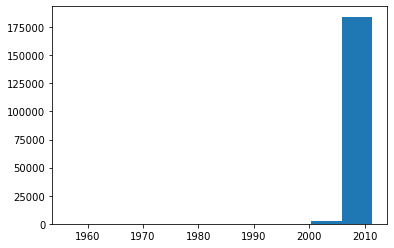

In [44]:
plt.hist(user_taggedartists_df['release_date'])

In [45]:
user_taggedartists_df['release_date'].max()

Timestamp('2011-05-09 00:00:00')

In [46]:
user_taggedartists_df['release_date'].min()

Timestamp('1956-06-01 00:00:00')

In [47]:
user_taggedartists_df['release_date'].value_counts()

2010-07-01    5170
2010-05-01    5124
2010-04-01    5116
2010-03-01    5030
2010-09-01    5001
              ... 
2005-09-01     150
1956-09-01       2
1956-06-01       1
1957-03-01       1
1979-05-01       1
Name: release_date, Length: 75, dtype: int64

In [48]:
(2011 - 1957) / 4

13.5

In [49]:
thresholdMin = pd.to_datetime('1956-06-01')
thresholdVeryOld = pd.to_datetime('1970-01-01') # represents the range from 1956 - 1970 
thresholdOld = pd.to_datetime('1984-01-01')# represents the range from 1970 - 1984 
thresholdNew = pd.to_datetime('1998-01-01')# represents the range from 1984 - 1998 
thresholdVeryNew = pd.to_datetime('2012-01-01')# represents the range from 1998 - 2012

In [50]:
user_taggedartists_df['very_old'] = ((user_taggedartists_df.release_date >= thresholdMin) & (user_taggedartists_df.release_date < thresholdVeryOld)).astype(int)
user_taggedartists_df['old'] = ((user_taggedartists_df.release_date >= thresholdVeryOld) & (user_taggedartists_df.release_date < thresholdOld)).astype(int)
user_taggedartists_df['new'] = ((user_taggedartists_df.release_date >= thresholdOld) & (user_taggedartists_df.release_date < thresholdNew)).astype(int)
user_taggedartists_df['very_new'] = ((user_taggedartists_df.release_date >= thresholdNew) & (user_taggedartists_df.release_date < thresholdVeryNew)).astype(int)

In [51]:
user_taggedartists_df.head()

,userID,artistID,tagID,release_date,very_old,old,new,very_new
0,2,52,13,2009-04-01,0,0,0,1
1,2,52,15,2009-04-01,0,0,0,1
2,2,52,18,2009-04-01,0,0,0,1
3,2,52,21,2009-04-01,0,0,0,1
4,2,52,41,2009-04-01,0,0,0,1


In [22]:
len(user_taggedartists_df)

186479

In [52]:
tags_df = pd.read_table('Data-20220224/Data Group Assignment/tags.dat',encoding='latin-1')

In [53]:
tags_df.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [54]:
tags_df.tagValue.value_counts()

metal                                        1
absolute bomb rock-punk track                1
gorgeous world pop track                     1
tribal womne of the amazon rocks my world    1
cool mano negra cover                        1
                                            ..
question of honor                            1
luna                                         1
astrrid hadad                                1
in the kingdom of darkness                   1
electro latino                               1
Name: tagValue, Length: 11946, dtype: int64

In [117]:
merged = pd.merge(user_taggedartists_df,tags_df,how='inner',on='tagID')

In [118]:
merged.head()

,userID,artistID,tagID,release_date,very_old,old,new,very_new,tagValue
0,2,52,13,2009-04-01,0,0,0,1,chillout
1,2,63,13,2009-04-01,0,0,0,1,chillout
2,2,73,13,2009-04-01,0,0,0,1,chillout
3,2,94,13,2009-04-01,0,0,0,1,chillout
4,2,6177,13,2009-05-01,0,0,0,1,chillout


In [122]:
merged['genres'] = merged.groupby(['userID','artistID'])['tagValue'].transform(lambda x : ' '.join(x))

In [125]:
merged.groupby('artistID').head()

,userID,artistID,tagID,release_date,very_old,old,new,very_new,tagValue,genres
0,2,52,13,2009-04-01,0,0,0,1,chillout,chillout downtempo electronic trip-hop female ...
1,2,63,13,2009-04-01,0,0,0,1,chillout,chillout ambient new age gregorian chant
2,2,73,13,2009-04-01,0,0,0,1,chillout,chillout downtempo electronic trip-hop ambient...
3,2,94,13,2009-04-01,0,0,0,1,chillout,chillout downtempo trip-hop lounge acid jazz c...
4,2,6177,13,2009-05-01,0,0,0,1,chillout,chillout downtempo ambient lounge cafe del mar
...,...,...,...,...,...,...,...,...,...,...
186448,2096,13890,12642,2010-12-01,0,0,0,1,gluhie 90e,americana gluhie 90e symbiosis
186465,2096,9206,12643,2011-03-01,0,0,0,1,scott pilgrim,usa scott pilgrim
186467,2096,18597,12643,2011-03-01,0,0,0,1,scott pilgrim,scott pilgrim
186477,2096,13890,12645,2010-09-01,0,0,0,1,symbiosis,americana gluhie 90e symbiosis


In [ ]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')


encoded_cols = enc.fit_transform(merged[['genres']]).toarray()

column_names = enc.get_feature_names(['genres'])

enc_df = pd.DataFrame(encoded_cols,columns=column_names)

df_one_hot = pd.concat([merged,enc_df],axis=1)
df_one_hot.head()

In [ ]:
content_df = df_one_hot.drop(columns=['release_date','tagValue','genres','userID'])

## Hybrid Recommender Systems

In [31]:
user_artist_categorized = pd.read_csv('user_artists_categorized.csv')

In [32]:
user_artist_categorized.head()

,userID,artistID,weight_quantiles
0,2,51,4
1,2,52,4
2,2,53,4
3,2,54,4
4,2,55,4


In [33]:
#create train and test sets 
UA_train, UA_test = train_test_split(user_artist_categorized,test_size=0.3,random_state=123)

UA_train = UA_train.reset_index(drop=True)
UA_test = UA_test.reset_index(drop=True)

In [34]:
#create reader object 
reader = Reader(rating_scale=(1,5)) #1:5 scale 

#create surprise train and test set objects
data = Dataset.load_from_df(user_artist_categorized[["userID","artistID","weight_quantiles"]], reader)
UA_train = Dataset.load_from_df(UA_train, reader).build_full_trainset()
UA_test = list(UA_test.itertuples(index=False, name=None))

In [35]:
#get baseline KNN score 
from surprise import KNNBasic

# create options dict; use cosine similarity on user_based data
options = {'name':'cosine', 'user_based':True}

ubKNN = KNNBasic(k=20, min_k=5, sim_options=options, random_state=123)

#create cosine similarity matrix
ubKNN.fit(UA_train)\
.compute_similarities()

Computing the cosine similarity matrix...


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


array([[1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.96559438, ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.96559438, 1.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        1.        ]])

In [36]:
ub_preds = ubKNN.test(UA_test)

In [37]:
#get baseline KNN score 
from surprise import KNNBasic


svd = SVD(n_factors=20, n_epochs=20, biased=True,random_state=123)

#create cosine similarity matrix
svd.fit(UA_train)\
.compute_similarities()

array([[1.   , 0.5  , 0.2  , ..., 0.   , 0.   , 0.   ],
       [0.5  , 1.   , 0.375, ..., 0.   , 0.   , 1.   ],
       [0.2  , 0.375, 1.   , ..., 0.   , 0.   , 0.5  ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.5  , ..., 0.   , 0.   , 1.   ]])

In [38]:
svd_preds = svd.test(UA_test)

In [39]:
models = {"UB_KNN":ub_preds, "SVD":svd_preds}
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=2) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

,UB_KNN,SVD
RMSE,1.394226,0.907108
MAE,1.184893,0.737216
Recall,0.615016,0.784936
Precision,0.708707,0.914353
F1,0.658546,0.844716
NDCG@5,0.866164,0.871942


In [40]:
# Combine predictions (mean)

# extract predictions content-based and item-based
df_pred_ub_KNN, df_pred_svd = pd.DataFrame(ub_preds), pd.DataFrame(svd_preds)

df_hybrid = df_pred_ub_KNN.copy()
df_hybrid['est'] = (np.array(df_pred_ub_KNN['est']) + np.array(df_pred_svd['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,843,10570,0,1.498138,"{'was_impossible': True, 'reason': 'User and/o..."
1,189,492,3,2.573330,"{'actual_k': 15, 'was_impossible': False}"
2,227,543,1,2.129309,"{'actual_k': 20, 'was_impossible': False}"
3,1340,10662,3,2.410101,"{'was_impossible': True, 'reason': 'User and/o..."
4,517,703,2,1.952635,"{'actual_k': 19, 'was_impossible': False}"


In [41]:
eval.evaluate(df_hybrid,topn=5,rating_cutoff=2)

,value
RMSE,1.088568
MAE,0.929834
Recall,0.842234
Precision,0.853321
F1,0.847742
NDCG@5,0.864574


In [42]:
df_pred_ub_KNN

,uid,iid,r_ui,est,details
0,843,10570,0,1.996276,"{'was_impossible': True, 'reason': 'User and/o..."
1,189,492,3,2.458521,"{'actual_k': 15, 'was_impossible': False}"
2,227,543,1,2.038612,"{'actual_k': 20, 'was_impossible': False}"
3,1340,10662,3,1.996276,"{'was_impossible': True, 'reason': 'User and/o..."
4,517,703,2,2.528017,"{'actual_k': 19, 'was_impossible': False}"
...,...,...,...,...,...
27846,1579,1109,4,2.410597,"{'actual_k': 17, 'was_impossible': False}"
27847,1795,485,2,2.899309,"{'actual_k': 20, 'was_impossible': False}"
27848,1003,159,3,2.947368,"{'actual_k': 19, 'was_impossible': False}"
27849,1323,1378,3,2.181689,"{'actual_k': 16, 'was_impossible': False}"


In [43]:
df_pred_svd.rename(columns={'est':'svd_est','r_ui':'target'},inplace=True)

In [45]:
df_pred_svd = df_pred_svd[['target','svd_est']]

In [46]:
df_pred_svd

,target,svd_est
0,0,1.000000
1,3,2.688139
2,1,2.220006
3,3,2.823927
4,2,1.377254
...,...,...
27846,4,3.133586
27847,2,1.810834
27848,3,2.578435
27849,3,2.231235


In [48]:
df_pred_ub_KNN = df_pred_ub_KNN.rename(columns={'est':'ub_KNN'})

In [49]:
df_pred_ub_KNN = df_pred_ub_KNN[['ub_KNN']]

In [57]:
data = pd.concat([df_pred_svd,df_pred_ub_KNN],axis=1)

In [58]:
rf_train, rf_test = train_test_split(data,test_size=0.2,random_state=123)

In [59]:
from sklearn.ensemble import RandomForestRegressor

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [63]:
rf_test.drop(columns=['target'],inplace=True)
rf_test.reset_index(drop=True,inplace=True)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [67]:
# predict
rf_pred = rf_model.predict(rf_test)

# transform in surprise format
rf_pred

array([3.87586898, 3.08027227, 1.0969231 , ..., 3.05394607, 2.13223222,
       2.81834731])